# 准备工作
先导入相关的模块，并将数据加载进内存，以便后面进行数据处理

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## 数据清洗

### 显示数据的摘要信息

加载数据后，将数据分成数据集和标签集，并展示数据的组成与摘要信息

In [2]:
data = pd.read_csv('./titanic/train.csv')

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


### 分析数据

通过统计发现`Cabin`字段缺失了绝大部份，而且由于其是枚举字段，无法进行填充，所以直接舍弃；对应的`PassengerId`和`Name`都是指代旅客的唯一编码，这里数据中保留数值类型的,并将其转换为索引；`Ticket`是船票的编号，是唯一编码，同样不将其作为有效特征；`Embarked`作为登船的地点，也是旅客的重要特征，而其作为一个枚举值，需要对其使用`OneHot`编码变成数值型数据

In [5]:
data = data.set_index(['PassengerId'])#将旅客ID设置为索引
data, labels = data.drop(['Survived','Name', 'Ticket', 'Cabin'], axis=1), data['Survived']#分离数据集为数据和标签

In [6]:
data.describe()# 显示数值型数据的摘要信息

,Pclass,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,20.125000,0.000000,0.000000,7.910400
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,38.000000,1.000000,0.000000,31.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
1,3,male,22.0,1,0,7.2500,S
2,1,female,38.0,1,0,71.2833,C
3,3,female,26.0,0,0,7.9250,S
4,1,female,35.0,1,0,53.1000,S
5,3,male,35.0,0,0,8.0500,S


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1115ff4a8>,
      dtype=object)

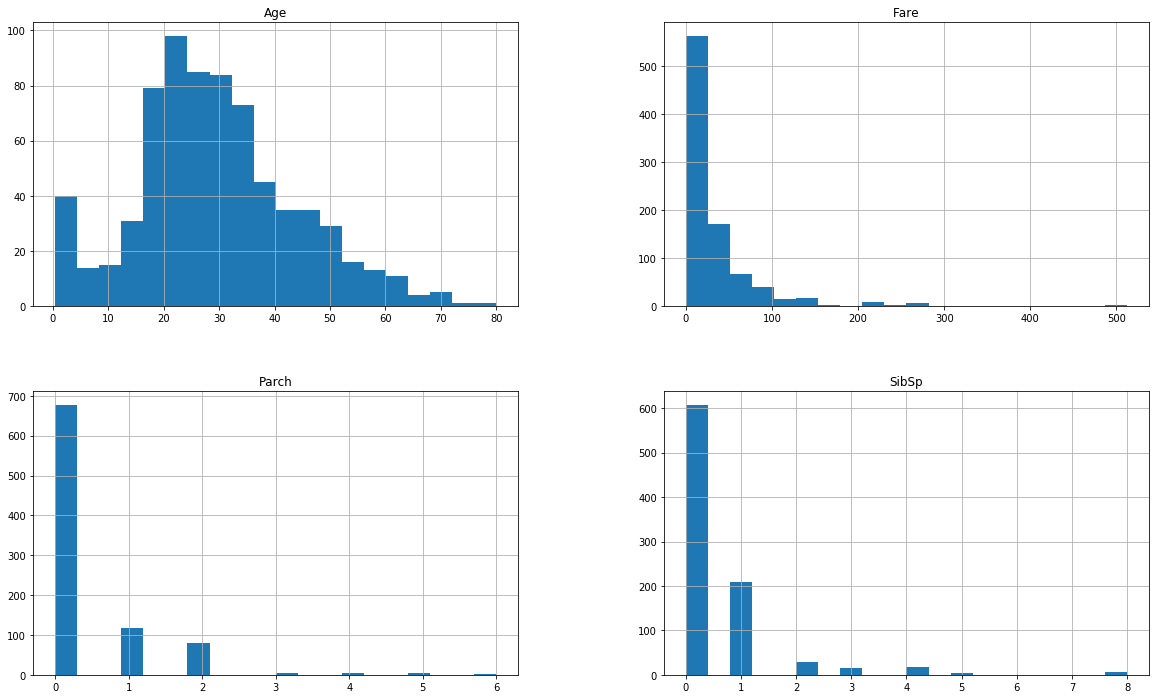

In [8]:
data[['Age', 'SibSp', 'Parch', 'Fare']].hist(figsize=(20, 12), bins=20, align='mid')#显示数据的直方图

从直方图的分布可以看出旅客的年龄主要分布是`18~35`岁之间，而旅费大多低于`50`，父母孩子和兄弟配偶的分布看出大多数人都是单人出游

In [9]:
data[['Age', 'SibSp', 'Parch', 'Fare']].corr()#查看各个特征的相关关系

,Age,SibSp,Parch,Fare
Age,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.308247,1.000000,0.414838,0.159651
Parch,-0.189119,0.414838,1.000000,0.216225
Fare,0.096067,0.159651,0.216225,1.000000


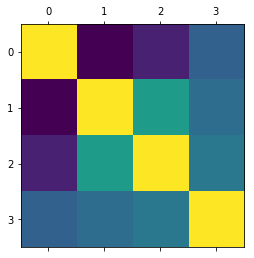

In [10]:
cor = data[['Age', 'SibSp', 'Parch', 'Fare']].corr()#绘制相关性矩阵
plt.matshow(cor)

相关性矩阵中越亮表示正相关性越高，越暗表示负相关性越高；从矩阵中可以看出票的等级`Age`和费用`SibSp`存在较为明显的正相关性

### 数据处理

在这个阶段需要排除无用的特征，填充缺失值

In [11]:
# 分割数据集
from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(data, labels)
x_train = data
y_train = labels

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

#列选择器
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attributes_name):
        self.attributes_name = attributes_name
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.attributes_name]
#字符串类型使用最多的类型填写    
class StringImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                       index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [13]:
# 创建数据处理管道
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import FeatureUnion
# 对类别型数据进行one-hot编码
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(['Sex', 'Embarked', 'Pclass'])),#选择类别数据
    ('impute', StringImputer()),#使用最多的类别填充
    ('binary', OneHotEncoder(sparse=False))#One-Hot编码
])

# 对数值型数据进行处理
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(['Age', 'SibSp', 'Parch', 'Fare'])),#选择数值型数据
    ('impute', SimpleImputer(strategy='median')),#以中位数填充空值
    ('std',  StandardScaler())#对数值进行标准化
])

# # # 选取其它数据
# other_pipeline = Pipeline([
#     ('selector', DataFrameSelector(['Pclass', 'SibSp', 'Parch']))
# ])

# 使用FeatureUnion联合各个Pipeline获取数据
full_pipeline = FeatureUnion(transformer_list=[
    ('cat_pipeline', cat_pipeline),
    ('num_pipeline', num_pipeline),
#     ('other_pipeline', other_pipeline)
])

x_train = full_pipeline.fit_transform(x_train)

# 选择模型
在对数据进行处理之后，剩下的就是选择模型了，模型的选择需要合适的指标来度量模型的好坏；在分类中的度量标准一般有`F1-score`和`ROC`曲线；准确率和召回率同样是衡量一个模型好坏的必要指标，准确率测量的是模型预测的准确度，召回率测量的是实际中被预测准确的概率

In [14]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
def plot_recall_predict_curve(precisions, recalls, threshold, xlim=[-5,5]):
    #画出预测和召回曲线
    plt.plot(threshold, precisions[:-1], 'b--', label='Precision')
    plt.plot(threshold, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center right')
    plt.ylim([0, 1])
    plt.xlim(xlim)
    
def plot_roc_curve(fpr, tpr, label=None):
    #画出roc曲线
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    

In [15]:
sgd_clf = SGDClassifier(max_iter=500, tol=1e-3, loss='log', random_state=42)
sgd_pred = cross_val_predict(sgd_clf, x_train, y_train, cv=7)
accuracy_score(y_train, sgd_pred)#准确率

0.7721661054994389

In [16]:
precision_score(y_train, sgd_pred)#预测

0.7768924302788844

In [17]:
recall_score(y_train, sgd_pred)#召回

0.5701754385964912

In [18]:
f1_score(y_train, sgd_pred)#f1分数

0.6576728499156829

In [19]:
sgd_pred = cross_val_predict(sgd_clf, x_train, y_train, cv=7, method='decision_function')

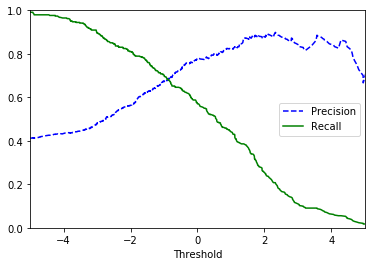

In [20]:
precisions, recalls, threshold = precision_recall_curve(y_train, sgd_pred)
plot_recall_predict_curve(precisions, recalls, threshold)

0.8077605215223851

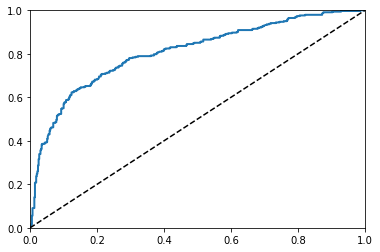

In [21]:
fpr, tpr, threshold = roc_curve(y_train, sgd_pred)
plot_roc_curve(fpr, tpr)
roc_auc_score(y_train, sgd_pred)

## 使用随机森林

In [22]:
from sklearn.model_selection import GridSearchCV
rf_clf = RandomForestClassifier(random_state=42)
param_grid = [
    {'n_estimators': [i for i in range(100, 500)]},
    {'max_depth': [i for i in range(2, 10)]}
]
grid_cv = GridSearchCV(rf_clf, param_grid, cv=3, n_jobs=-1, verbose=True)#查找最好的森林
grid_cv.fit(x_train, y_train)

Fitting 3 folds for each of 408 candidates, totalling 1224 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1217 out of 1224 | elapsed:  2.8min remaining:    1.0s
[Parallel(n_jobs=-1)]: Done 1224 out of 1224 | elapsed:  2.8min finished
/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_estimators': [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, ...8, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499]}, {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_

In [23]:
grid_cv.best_params_

{'max_depth': 6}

In [24]:
rf_pred = cross_val_predict(grid_cv.best_estimator_, x_train, y_train, cv=3)
accuracy_score(y_train, rf_pred)#准确率

0.8204264870931538

In [25]:
precision_score(y_train, rf_pred)#预测

0.8345588235294118

In [26]:
recall_score(y_train, rf_pred)#召回

0.6637426900584795

In [27]:
rf_pred = cross_val_predict(grid_cv.best_estimator_, x_train, y_train, 
                            cv=3, method='predict_proba')
rf_pred = rf_pred[:, 1]

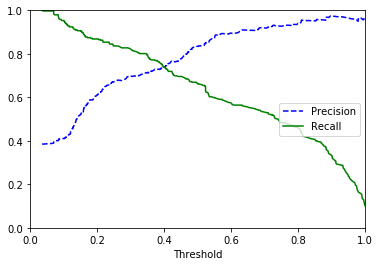

In [28]:
precisions, recalls, threshold = precision_recall_curve(y_train, rf_pred)
plot_recall_predict_curve(precisions, recalls, threshold, [0,1])

0.8559315714909618

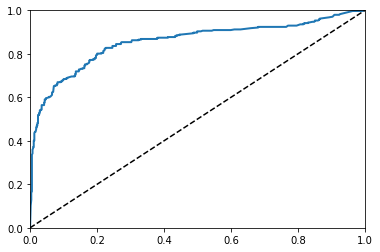

In [29]:
fpr, tpr, threshold = roc_curve(y_train, rf_pred)
plot_roc_curve(fpr, tpr)
roc_auc_score(y_train, rf_pred)

In [30]:
from sklearn.model_selection import learning_curve
train_size, train_scores, test_scores = learning_curve(grid_cv.best_estimator_, x_train, y_train, 
                                                       n_jobs=-1, verbose=True, cv=5, random_state=42)

[learning_curve] Training set sizes: [ 71 231 391 551 712]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.2s finished


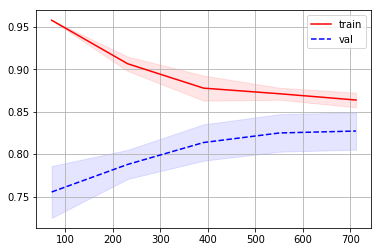

In [31]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_size, train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std, alpha=0.1,
                color='r')
plt.fill_between(train_size, test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std, alpha=0.1,
                color='b')
plt.plot(train_size, train_scores_mean, 'r-', label='train')
plt.plot(train_size, test_scores_mean, 'b--',label='val')
plt.legend(loc='best')

## 使用GBRT训练

In [32]:
from sklearn.ensemble import GradientBoostingClassifier
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': np.arange(2, 10)
}
grid_gbrt_cv = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid=param_grid, 
                            cv=3, verbose=True, n_jobs=-1)
grid_gbrt_cv.fit(x_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   28.7s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [100, 200, 300, 400, 500], 'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [33]:
grid_gbrt_cv.best_score_

0.8215488215488216

In [34]:
gbrt_pred = cross_val_predict(grid_gbrt_cv.best_estimator_, x_train, y_train, 
                              cv=5)
accuracy_score(gbrt_pred, y_train)

0.8260381593714927

In [35]:
precision_score(y_train, gbrt_pred)

0.8025889967637541

In [36]:
recall_score(y_train, gbrt_pred)

0.7251461988304093

0.8070175438596491

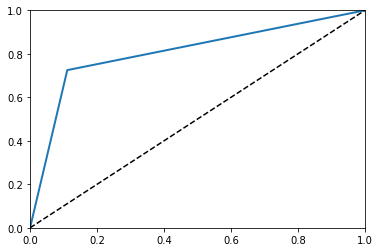

In [37]:
fpr, tpr, threshold = roc_curve(y_train, gbrt_pred)
plot_roc_curve(fpr, tpr)
roc_auc_score(y_train, gbrt_pred)

## 使用SVM

In [38]:
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

svm_param_grd = {
    'gamma': reciprocal(0.001, 0.1),
    'C': uniform(1, 10),
    'kernel': ['rbf', 'poly']
}
svm_rnd_search_cv = RandomizedSearchCV(SVC(probability=True, ), param_distributions=svm_param_grd, 
                                       n_jobs=-1, n_iter=10, cv=3, random_state=42)
svm_rnd_search_cv.fit(x_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x116b81978>, 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x116b81400>, 'kernel': ['rbf', 'poly']},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [39]:
svm_pred = cross_val_predict(svm_rnd_search_cv.best_estimator_, x_train, y_train, 
                             cv=5)
accuracy_score(svm_pred, y_train)

0.8316498316498316

In [40]:
precision_score(svm_pred, y_train)

0.7017543859649122

In [41]:
recall_score(svm_pred, y_train)

0.8333333333333334

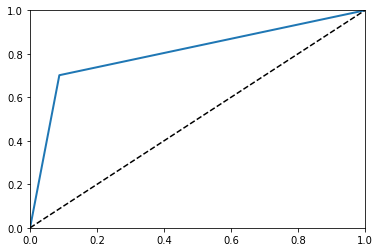

In [42]:
fpr, tpr, threshold = roc_curve(y_train, svm_pred)
plot_roc_curve(fpr, tpr)

## 综合以上所有模型

In [43]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
    estimators=[('sgd_clf', sgd_clf), 
                ('rf_clf', grid_cv.best_estimator_), 
                ('gbrt_clf', grid_gbrt_cv.best_estimator_), 
                ('svm_clf', svm_rnd_search_cv.best_estimator_)],
    voting='soft',
)


voting_pred = cross_val_predict(voting_clf, x_train, y_train, cv=5)
accuracy_score(voting_pred, y_train)

0.8338945005611672

In [44]:
precision_score(voting_pred, y_train)

0.7222222222222222

In [45]:
recall_score(voting_pred, y_train)

0.8233333333333334

0.8128415300546449

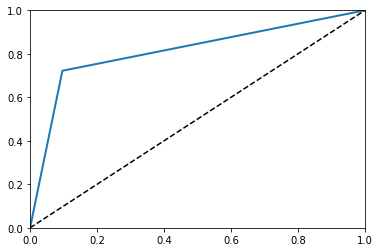

In [46]:
fpr, tpr, threshold = roc_curve(y_train, voting_pred)
plot_roc_curve(fpr, tpr)
roc_auc_score(y_train, voting_pred)

## 对比所有模型

In [47]:
fpr_sgd, tpr_sgd, threshold_sgd = roc_curve(y_train, sgd_pred)
fpr_rf, tpr_rf, threshold_rf = roc_curve(y_train, rf_pred)
fpr_gbrt, tpr_gbrt, threshold_gbrt = roc_curve(y_train, gbrt_pred)
fpr_svm, tpr_svm, threshold_svm = roc_curve(y_train, svm_pred)
fpr_voting, tpr_voting, threshold_voting = roc_curve(y_train, voting_pred)

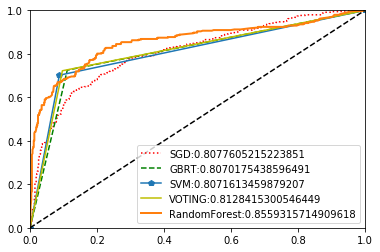

In [48]:
plt.plot(fpr_sgd, tpr_sgd, 'r:', label=('SGD:'+str(roc_auc_score(y_train, sgd_pred))))
plt.plot(fpr_gbrt, tpr_gbrt, 'g--', label=('GBRT:'+str(roc_auc_score(y_train, gbrt_pred))))
plt.plot(fpr_svm, tpr_svm, 'p-', label=('SVM:'+str(roc_auc_score(y_train, svm_pred))))
plt.plot(fpr_voting, tpr_voting, 'y-', label=('VOTING:'+str(roc_auc_score(y_train, voting_pred))))
plot_roc_curve(fpr_rf, tpr_rf, label=('RandomForest:'+str(roc_auc_score(y_train, rf_pred))))
plt.legend(loc='lower right')

# 使用投票预测

In [49]:
test = pd.read_csv('./titanic/test.csv')
index = np.array(test[['PassengerId']])[:,0]
test = test.set_index('PassengerId')
test = full_pipeline.transform(test)
index.shape

(418,)

In [54]:
voting_clf.fit(x_train, y_train)
pred = voting_clf.predict(test)
pred_df = pd.DataFrame({'PassengerId':index,
                       'Survived':pred})

In [55]:
pred_df.to_csv('./titanic/prediction.csv', index='')